# [7] Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [4]:
%matplotlib inline

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import cross_validation
from sklearn.naive_bayes import MultinomialNB

C:\Users\Dileep\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
%matplotlib inline



# using the SQLite Table to read data.
con = sqlite3.connect('./database.sqlite') 



#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3
""", con) 




# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [6]:
positiveNegative.shape

(525814,)

In [7]:
filtered_data.shape #looking at the number of attributes and size of the data
filtered_data.head()

Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator     Score        Time  \
0                     1                       1  positive  1303862400   
1                     0                       0  negative  1346976000   
2                     1                       1  positive  1219017600   
3                     3                       3  negative  1307923200   
4                     0                       0  positive  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...  
3         Cough Medicine  If you are looking for the secret ingredient i...  
4            Great taffy  Great taffy at a great price.  There was a wid...

#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

# Time Based Splitting 

In [9]:
#Sorting data according to Time Stamp in ascending order
sorted_data=filtered_data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]


In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)
label=np.array(final['Score'])

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [ ]:
minor=final[final.Score=='negative']
major=final[final.Score=='positive']
minor_sample=resample(minor,replace=True,n_samples=307061,random_state=123)
final=pd.concat([major,minor_sample])

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [13]:
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;    

        

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [14]:
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'so', 'of', "mustn't", 'here', "it's", "couldn't", 'but', 'below', 'where', 'they', "won't", 'because', 've', "shan't", 'above', 'having', 'who', 'the', "she's", 'then', "you'd", 'its', 'further', 'into', 'to', 'too', "you'll", 'o', 'shan', 'herself', 'doing', 'theirs', 'is', 'why', 'can', 'shouldn', 'or', 'an', 'been', 'she', 'me', 'how', 'same', 'y', 'against', 'up', 'both', 'between', 'this', 'again', 'hasn', 'don', 'whom', "hasn't", 'these', 'my', 'few', 'in', 'over', 's', 'wasn', 'off', 'ourselves', 'before', 'if', 'after', 'as', 'should', "aren't", 'we', 'under', "shouldn't", 'hers', 'are', 'was', 'some', 'm', 'doesn', 'on', "didn't", 'out', "don't", 'for', 'themselves', 'by', 'other', "isn't", 'all', 'll', 'your', 'needn', "that'll", 'with', 'about', 'while', 't', 'yourselves', 'nor', 'more', 'his', 'hadn', 'it', 'very', "wasn't", 'himself', 'that', 'yours', 'do', "needn't", 'yourself', 'during', 'ma', 'have', 'such', 're', "you're", "doesn't", 'ours', 'itself', 'there', 'mustn

In [15]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in final['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [50]:
final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
final['CleanedText']=final['CleanedText'].str.decode("utf-8")

In [53]:
print(final.head(3))#below the processed review can be seen in the CleanedText Column 


# store final table into an SQlLite table for future.
conn = sqlite3.connect('final.sqlite')
c=conn.cursor()
conn.text_factory = str
final.to_sql('Reviews', conn, flavor=None, schema=None, if_exists='replace', index=True, index_label=None, chunksize=None, dtype=None)

            Id   ProductId         UserId         ProfileName  \
138706  150524  0006641040  ACITT7DI6IDDL     shari zychinski   
138683  150501  0006641040  AJ46FKXOVC7NR  Nicholas A Mesiano   
417839  451856  B00004CXX9  AIUWLEQ1ADEG5    Elizabeth Medina   

        HelpfulnessNumerator  HelpfulnessDenominator     Score       Time  \
138706                     0                       0  positive  939340800   
138683                     2                       2  positive  940809600   
417839                     0                       0  positive  944092800   

                                                  Summary  \
138706                          EVERY book is educational   
138683  This whole series is great way to spend time w...   
417839                               Entertainingl Funny!   

                                                     Text  \
138706  this witty little book makes my son laugh at l...   
138683  I can remember seeing the show when it aired o...   
41

In [54]:
from sklearn import cross_validation
final_Train, final_Test, label_Train, label_Test = cross_validation.train_test_split(final,label, test_size=0.3, random_state=0)


# [7.2.2] Bag of Words (BoW)

In [55]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_Tr = count_vect.fit_transform(final_Train['CleanedText'].values)
final_Te = count_vect.transform(final_Test['CleanedText'].values)

In [56]:
final_Te.shape

(109252, 60218)

# k fold cross Validation

In [57]:

alphas = list(range(10,10000,10))
 

# empty list that will hold cv scores
cv_scores1 = []

# perform 10-fold cross validation
for k in alphas:
    BNB = MultinomialNB(alpha=k)
    scores = cross_val_score(BNB, final_Tr, label_Train, cv=10, scoring='accuracy')
    cv_scores1.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores1]

# determining best c
optimal_alpha = alphas[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is %d.' % optimal_alpha)


The optimal number of alpha is 10.


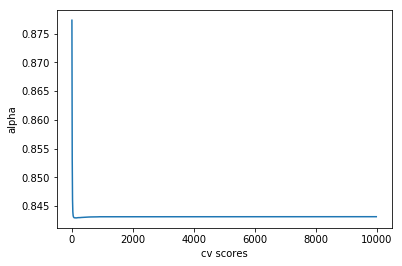

In [58]:
plt.plot(alphas,cv_scores1)
plt.xlabel('cv scores')
plt.ylabel('alpha')
plt.show()

In [59]:
BNB = MultinomialNB(optimal_alpha)
BNB.fit(final_Tr,label_Train)
pred= BNB.predict(final_Te)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for k ={} is {}".format(optimal_alpha,acc))


****Test accuracy for k =10 is 88.0935818108593


In [60]:
#feature importance
neg_class_prob_sorted = BNB.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = BNB.feature_log_prob_[1, :].argsort()
print("important negative features are::\n")
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print("\n\nimportant positve features are::\n")
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

important negative features are::

['aa' 'multidimension' 'multidisciplinari' 'multifactori' 'multifasciatus'
 'multiflavor' 'multifunct' 'multifuncut' 'multigallon' 'multigrano']


important positve features are::

['savingsforlittlebless' 'psls' 'microencapsul' 'emelmet' 'thevey' 'psi'
 'barritt' 'pseudonoodl' 'barrio' 'psep']


In [61]:
#confusion matrix
cm=confusion_matrix(label_Test,pred)

In [62]:
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false positives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 4820 
 false positives are 12308 
 false positives are 700
 true positives are 91424 
 


In [63]:
#accuracy score
accuracy_score(label_Test,pred)

0.880935818108593

In [64]:
#recall score
recall_score(label_Test,pred,pos_label='positive')

0.9924015457426947

In [65]:
precision_score(label_Test,pred,pos_label='positive')

0.8813480893070605

In [67]:
f1_score(label_Test,pred,pos_label='positive')

0.9335838575279798

In [68]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
print(df_cm)

      0      1
0  4820  12308
1   700  91424


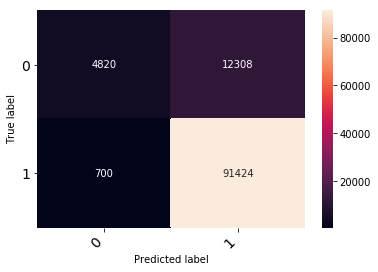

In [69]:
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# [7.2.5] TF-IDF

In [70]:

count_vect = TfidfVectorizer(ngram_range=(1,1)) #in scikit-learn
final_Tr = count_vect.fit_transform(final_Train['CleanedText'].values)
final_Te = count_vect.transform(final_Test['CleanedText'].values)


In [71]:
final_Tr.get_shape()


(254919, 60218)

In [72]:
features = count_vect.get_feature_names()
len(features)


60218

# k fold cross validation

In [36]:

alphas = list(range(10,10000,10))
alphas.append(1)

# empty list that will hold cv scores
cv_scores = []

# perform 10-fold cross validation
for k in alphas:
    BNB = MultinomialNB(alpha=k)
    scores = cross_val_score(BNB, final_Tr, label_Train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best alpha
optimal_alpha = alphas[MSE.index(min(MSE))]
print('\nThe optimal number of alpha is %d.' % optimal_alpha)


The optimal number of alpha is 1.


In [37]:
print(cv_scores)

[0.8431148721723238, 0.8431541000115542, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533, 0.8431580229647533,

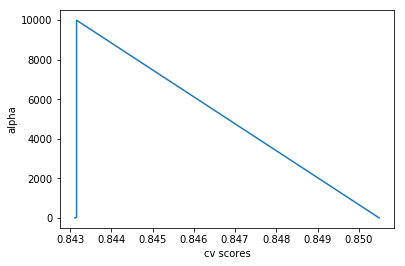

In [38]:
plt.plot(cv_scores,alphas)
plt.xlabel('cv scores')
plt.ylabel('alpha')
plt.show()

In [39]:
BNB = MultinomialNB(optimal_alpha)
BNB.fit(final_Tr,label_Train)
pred= BNB.predict(final_Te)
acc = accuracy_score(label_Test, pred, normalize=True) * float(100)
print("\n****Test accuracy for k ={} is {}".format(optimal_alpha,acc))


****Test accuracy for k =1 is 85.22040786438693


In [40]:
#feature importance
neg_class_prob_sorted = BNB.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = BNB.feature_log_prob_[1, :].argsort()
print("important negative features are::\n")
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
print("\n\nimportant positve features are::\n")
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

important negative features are::

['instahot' 'mandarina' 'mandarine' 'mandates' 'mandating' 'mande'
 'mandee' 'mandeling' 'mandeltorte' 'manderine']


important positve features are::

['excitotoxin' 'dasaquin' 'silicoalumionate' 'silicones' 'fke' 'darwish'
 'b001eo64f6' 'juke' 'b001eo653m' 'b001eo6852']


In [41]:
#confusion matrix
cm=confusion_matrix(label_Test,pred)

In [42]:
tn, fp, fn, tp = confusion_matrix(label_Test,pred).ravel()
print(" true negitves are {} \n false positives are {} \n false negatives are {}\n true positives are {} \n ".format(tn,fp,fn,tp))

 true negitves are 1038 
 false positives are 16090 
 false negatives are 57
 true positives are 92067 
 


In [43]:
#accuracy score
accuracy_score(label_Test,pred)

0.8522040786438693

In [44]:
#recall score
recall_score(label_Test,pred,pos_label='positive')

0.9993812687247623

In [45]:
precision_score(label_Test,pred,pos_label='positive')

0.8512347790711651

In [46]:
f1_score(label_Test,pred,pos_label='positive')

0.9193782735256965

In [47]:
index_names=['0','1']
class_names=['0','1']
df_cm = pd.DataFrame(cm, index=index_names, columns=class_names)
print(df_cm)

      0      1
0  1038  16090
1    57  92067


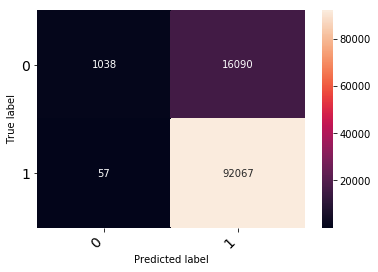

In [48]:
hp =sns.heatmap(df_cm, annot=True, fmt="d")
hp.yaxis.set_ticklabels(hp.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
hp.xaxis.set_ticklabels(hp.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# table to compare vectors trained using MultiNomial Naive Bayes

|score     |  Bag of Words  | Tf-idf |
|--------------------------------|----------------------------|-----------------------------------|
|hyperparameter(alpha)| 10 | 1 |
|--------------------------------|----------------------------|-----------------------------------|
|Test accuracy|88.0935818108593|85.22040786438693|
|--------------------------------|----------------------------|-----------------------------------|
|true negatives|4820|1038|
|--------------------------------|----------------------------|-----------------------------------|
|true positives|91424|92067|
|--------------------------------|----------------------------|-----------------------------------|
|false positives|12308|16090|
|--------------------------------|----------------------------|-----------------------------------|
|false negatives|700|57|
|--------------------------------|----------------------------|-----------------------------------|
|f1 score|0.9335838575279798|0.9193782735256965|
|--------------------------------|----------------------------|-----------------------------------|
|prescision score|0.8813480893070605|0.8512347790711651|
|--------------------------------|----------------------------|-----------------------------------|
|recall score|0.9924015457426947|0.9993812687247623|
|--------------------------------|----------------------------|-----------------------------------|
|accuracy score|0.880935818108593|0.8522040786438693|
|--------------------------------|----------------------------|-----------------------------------|

# conclusion

1.By applying Naive bayes to the above two vectors Test accuracy for tf idf vector is more than Bag of Words

2.tf-idf has better f1 score when compard to Bow

3.recall,prescion scores are slightly higher to Bow when Compared to tfidf

4.So,according to Observations I am Concluding that Using tf idf vector for Naive Bayes is Better than Bag of Words